# HOTEL BOOKING CANCELLATION

Author: Caio Nunes (caiocsn@hotmail.com)

Date: 2022-03-12

# Loading packages

In [1034]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate, ShuffleSplit

# Loading data

In [954]:
data = pd.read_csv('cancellation_prediction.csv', parse_dates= {'date' : ['year_arrival_date',
                                                                          'month_arrival_date',
                                                                          'day_of_month_arrival_date']})
data['booking_month'] = data['date'].apply(lambda x: x.month)
data

date         type  cancellation  days_between_booking_arrival  \
0      2015-07-01  Fancy Hotel             0                           342   
1      2015-07-01  Fancy Hotel             0                           737   
2      2015-07-01  Fancy Hotel             0                             7   
3      2015-07-01  Fancy Hotel             0                            13   
4      2015-07-01  Fancy Hotel             0                            14   
...           ...          ...           ...                           ...   
119385 2017-08-30        Hotel             0                            23   
119386 2017-08-31        Hotel             0                           102   
119387 2017-08-31        Hotel             0                            34   
119388 2017-08-31        Hotel             0                           109   
119389 2017-08-29        Hotel             0                           205   

        week_number_arrival_date  num_weekend_nights  num_workweek_nights  \
0                             27                   0                    0   
1                             27                   0                    0   
2                             27                   0                    1   
3                             27                   0                    1   
4                             27                   0                    2   
...                          ...                 ...                  ...   
119385                        35                   2                    5   
119386                        35                   2                    5   
119387                        35                   2                    5   
119388                        35                   2                    5   
119389                        35                   2                    7   

        num_adults  num_children  num_babies  ...  reserved_room  \
0                2           0.0           0  ...              C   
1                2           0.0           0  ...              C   
2                1           0.0           0  ...              A   
3                1           0.0           0  ...              A   
4                2           0.0           0  ...              A   
...            ...           ...         ...  ...            ...   
119385           2           0.0           0  ...              A   
119386           3           0.0           0  ...              E   
119387           2           0.0           0  ...              D   
119388           2           0.0           0  ...              A   
119389           2           0.0           0  ...              A   

       changes_between_booking_arrival  deposit_policy  \
0                                    3      No Deposit   
1                                    4      No Deposit   
2                                    0      No Deposit   
3                                    0      No Deposit   
4                                    0      No Deposit   
...                                ...             ...   
119385                               0      No Deposit   
119386                               0      No Deposit   
119387                               0      No Deposit   
119388                               0      No Deposit   
119389                               0      No Deposit   

        id_travel_agency_booking  id_person_booking  customer_type  avg_price  \
0                            NaN                NaN              0       0.00   
1                            NaN                NaN              0       0.00   
2                            NaN                NaN              0      75.00   
3                          304.0                NaN              0      75.00   
4                          240.0                NaN              0      98.00   
...                          ...                ...            ...        ...   
119385                     394.0                NaN              0    

# Fixing missing values

In [955]:
data.isna().sum()/len(data)

date                               0.000000
type                               0.000000
cancellation                       0.000000
days_between_booking_arrival       0.000000
week_number_arrival_date           0.000000
num_weekend_nights                 0.000000
num_workweek_nights                0.000000
num_adults                         0.000000
num_children                       0.000034
num_babies                         0.000000
breakfast                          0.000000
country                            0.004087
market_segment                     0.000000
distribution_channel               0.000000
repeated_guest                     0.000000
num_previous_cancellations         0.000000
num_previous_stays                 0.000000
reserved_room                      0.000000
changes_between_booking_arrival    0.000000
deposit_policy                     0.000000
id_travel_agency_booking           0.136862
id_person_booking                  0.943069
customer_type                   

### Country

The country variable has less the 1% of missing values, we'll simply drop the rows with no contry data.

In [956]:
data = data[data['country'].notna()]

### Travel agency

As the id of the booking company can still be useful to us and its level of complite is pretty fair we will be filling the missing values with 0. This way we'll be able to identify the bookings that hasn't came from an agency.

In [957]:
data['id_travel_agency_booking'] = data['id_travel_agency_booking'].fillna(0)

<ipython-input-957-2f7e4864a2db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['id_travel_agency_booking'] = data['id_travel_agency_booking'].fillna(0)


### Person ID

We'll drop this column, with this level of incompleteness there is no much we can do for now.

In [958]:
data = data.drop(columns = 'id_person_booking')

# Balancing the dataset

As our main task here is to build a classification model using this dataset as input, it's prudent to balance the dataset according to the target variable 'cancellation'.

<AxesSubplot:xlabel='cancellation', ylabel='count'>

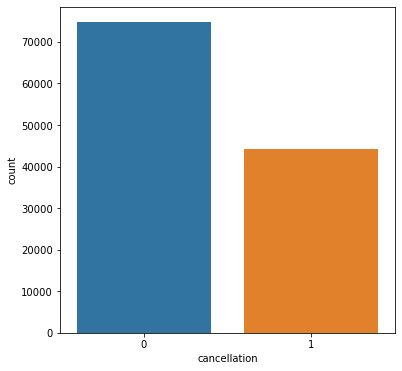

In [959]:
plt.figure(figsize = (6,6))
sns.countplot(x = data['cancellation'])

<AxesSubplot:xlabel='cancellation', ylabel='count'>

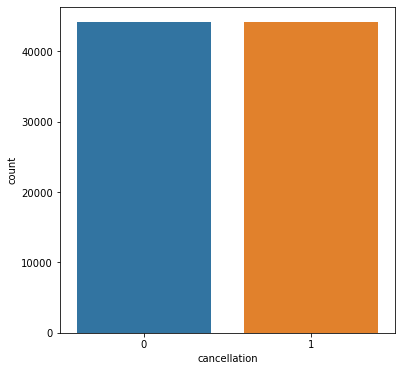

In [960]:
df1 = data[data['cancellation'] == 1]
df2 = data[data['cancellation'] == 0].sample(n = len(df1), replace = False)
b_data = df1.append(df2, ignore_index = True).sample(frac = 1)

del df1
del df2

plt.figure(figsize = (6,6))
sns.countplot(x = b_data['cancellation'])

# Creating new variables

**fancy_hotel?** - Creating a better intepretable variable for the type column

**booking_arrival_distance** - Dividing the 'days_between_booking_arrival' variable into parcetiles

**total_nights** - Getting the total number of nights per booking

**num_of_guests** - Total number of guests including adults, children and babies

**cancelled_before?** - Wheter this booking has been cancellated before or not

**booking_changesd** - Has this booking been changed befored?

**agency?** - Wheter the reservation came from a travel agency or not

**hotel_price_range** - Dividing 'avg_price' into categories

**required_parking_space?** - Wheter the costumer has required parking spaces or not

**specia_requests?** - Has the costumer made any special requests?

**year_season** - The season of the year of the booking date


In [961]:
def feature_engineering(data):
    data_ = data.copy()
    
    data_['fancy_hotel?'] = (data_['type'] == 'Fancy Hotel').astype(int)
    data_['booking_arrival_distance'] = pd.qcut(data_['days_between_booking_arrival'], 5, 
             labels = list(range(5)))
    data_['total_nights'] = data_['num_weekend_nights'] +  data_['num_workweek_nights']
    data_['num_of_guests'] = data_['num_adults'] + data_['num_children'] + data_['num_babies']
    data_['cancellled_before?'] = (data_['num_previous_cancellations'] > 0).astype(int)
    data_['booking_changed?'] = (data_['changes_between_booking_arrival'] > 0).astype(int)
    data_['agency?'] = (data_['id_travel_agency_booking'] != 0).astype(int)
    data_['hotel_price_range'] = pd.qcut(data_['avg_price'], 3, list(range(3))).astype(str)
    data_.loc[data_['avg_price'] > 200, 'hotel_price_range'] = 3
    data_['required_parking_space?'] = (data_['required_car_parking_spaces'] > 0).astype(int)
    data_['special_requests?'] = (data_['total_of_special_requests'] > 0).astype(int)
    def season_by_month(date):
        seasons = ['winter', 'spring', 'summer', 'fall']
        idx = date.month%12 // 3
        return seasons[idx]

    data_['year_season'] = data_['date'].apply(season_by_month)
    
    return data_

b_data = feature_engineering(b_data)

# Removing outliers

For this analysis we will not go deeper looking for outliers in the dataset. For now we'll remove some unconsciousness such as bookings without any guests or with zero reserved nights.


In [962]:
sel = (b_data['num_of_guests'] > 0) & (b_data['total_nights'] > 0)
b_data = b_data[sel]

# Exploratory data analysis


### Temporal analysis

We will investigate the relation between the data features and the target variable 'cancellation'.

<AxesSubplot:title={'center':'Cancellation ratio over the time'}, xlabel='date', ylabel='cancellation'>

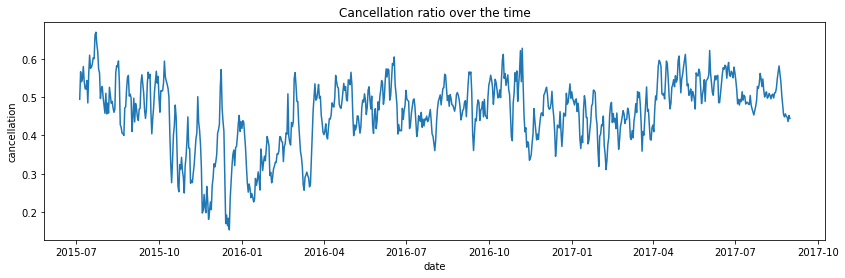

In [963]:
cancellation_series = b_data.groupby('date').agg({'cancellation': lambda x: sum(x)/len(x)}).reset_index()
cancellation_series['cancellation'] = cancellation_series['cancellation'].rolling(window=5).mean()
plt.figure(figsize = (14, 4))
plt.title('Cancellation ratio over the time')
sns.lineplot(data = cancellation_series, y = 'cancellation', x = 'date')

Text(0.5, 1.0, 'Trend')

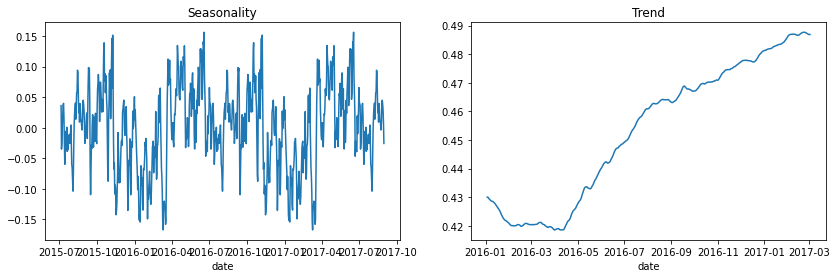

In [964]:
try:
    cancellation_series = cancellation_series.set_index('date')
except KeyError:
    pass
decompose_result = seasonal_decompose(cancellation_series.dropna(), model = 'additive', period = 365)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.lineplot(ax = ax[0], y = decompose_result.seasonal.values, x = decompose_result.seasonal.index)
ax[0].set_title('Seasonality')
sns.lineplot(ax = ax[1], y = decompose_result.trend.values, x = decompose_result.trend.index)
ax[1].set_title('Trend')


 - As expected the cancellation event is somehow depedent of temporal features like the month and season of the year for which the reservation was made for. 

- Additionally, the series is displaying positive trend and so it's expected for the cancellation ratio to increase over the time.



### Features analysis
From now on we'll divide the columns in three groups:
1.  Hotel data
2.  Costumer data
3.  Booking data

This approach will keep the analysis organized and will facilitate the results interpretation. 

In [965]:
def bootstraping_prob(data, feature, n = 15):
    result = pd.DataFrame()
    for i in range(n):
        iteration = data.sample(frac=1, replace = True).groupby(feature).agg({'cancellation': lambda x: x.sum()/len(x)}).transpose()
        result = result.append(iteration, ignore_index = True)
    return result



#### Hotel data

In [966]:
hotel_features = ['country', 'market_segment', 'fancy_hotel?', 'deposit_policy', 'cancellation']

In [967]:
def bootstraping_prob(data, feature, n = 15):
    bs_samples = pd.DataFrame()
    for i in range(n):
        iteration = data.sample(frac=0.1, replace = True).groupby(feature).agg({'cancellation': lambda x: x.sum()/len(x)}).transpose()
        bs_samples = bs_samples.append(iteration, ignore_index = True)
    
    result = pd.DataFrame()
    for col in bs_samples.columns:
        mean = bs_samples[col].median()
        lower_bound = np.round(bs_samples[col].quantile(0.05), 2)
        upper_bound = np.round(bs_samples[col].quantile(0.95), 2)
        result = result.append({'category': col, 'mean': mean, 'confidence_interval': (lower_bound, upper_bound)},
                              ignore_index = True)
    return result

def get_cancellation_prob(data, feature):
    x = data.groupby(feature).agg({'cancellation': lambda x: sum(x)/len(x)})
    x.columns = ['cancelled']
    x['not_cancelled'] = 1 - x['cancelled']
    return x.plot(kind = 'bar', stacked = True, figsize = (8,6))

##### Market Segment

This variable represents the market segment the hotel belongs to. 

- Categories 4 and 7 have very low representation in the dataset.
- Categories 2 and 3 have seems to have equal probability of suffering a cancellation or not.
- Categories 0, 1 and 4 have low propability of cancellation.
- Category 5 has a high cancellation chance.
- It was not possible to make trustable conclusions about market segment 7 hotels.
- We will replace this columns by two binary features 'high_cancellation_market' and 'low_cancellation_market' 

In [993]:
def get_high_cancellation_market(data):
    result = (data['market_segment'] == 5).astype(int)
    return result
def get_low_cancellation_market(data):
    result = (data['market_segment'].isin([0,1,4])).astype(int)
    return result

In [968]:
b_data['market_segment'].value_counts(normalize = True)

2    0.473523
3    0.200430
5    0.188988
0    0.091517
1    0.038631
4    0.005260
7    0.001651
Name: market_segment, dtype: float64

In [969]:
bootstraping_prob(b_data, 'market_segment', n = 100)

category confidence_interval      mean
0       0.0        (0.21, 0.27)  0.240296
1       1.0        (0.25, 0.32)  0.287976
2       2.0        (0.49, 0.51)  0.496808
3       3.0        (0.45, 0.48)  0.469839
4       4.0         (0.09, 0.3)  0.202041
5       5.0        (0.71, 0.74)  0.726971
6       7.0         (0.1, 0.61)  0.333333

<AxesSubplot:xlabel='market_segment'>

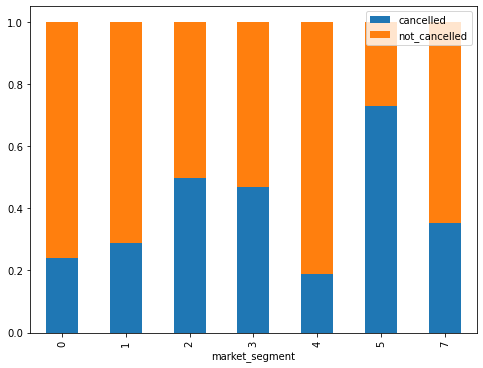

In [970]:
get_cancellation_prob(b_data, 'market_segment')

##### Fancy hotel?

The variable represents the fact of wheter the hotel is or not part of a more sofisticated category. The variable is binary and both classes have a fair representation.

- Fancy hotels have about 40% cancellation probability (under the average).
- Normal hotels have about 55% cancellation probability (slightly over the average).



In [971]:
b_data['fancy_hotel?'].value_counts(normalize = True)

0    0.684724
1    0.315276
Name: fancy_hotel?, dtype: float64

In [972]:
bootstraping_prob(b_data, 'fancy_hotel?', n = 100)

category confidence_interval      mean
0       0.0        (0.54, 0.56)  0.548266
1       1.0        (0.39, 0.41)  0.399928

<AxesSubplot:xlabel='fancy_hotel?'>

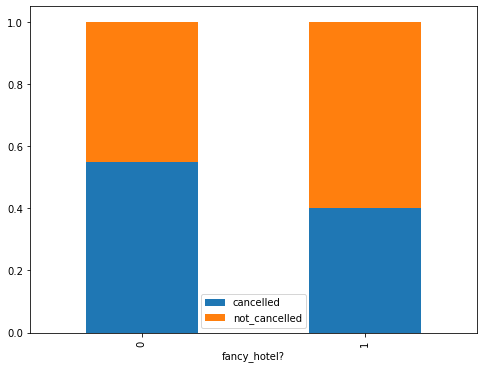

In [973]:
get_cancellation_prob(b_data, 'fancy_hotel?')

##### Country

The dataset has 162 unique countries, we conduced the analysis with the 14 most frequent ones.

- The cancellation ratio displays great variation according to the hotel country, for instance: PRT has about 70% cancellation ratio while FRA has only 27%.

- As this feature has a huge number of unique values we will be replacing it by the corresponding target variable probability so the prediction model will be able to extract more value from it.

In [1082]:
def get_p_country(data):
    most_frequent_countries = data['country'].value_counts(normalize = True)[:14].index
    p_target = bootstraping_prob(data[data['country'].isin(most_frequent_countries)], 'country', n = 100)
    result = pd.merge(data, p_target, how = 'left', left_on = 'country', right_on = 'category')['mean'].fillna(0.5).values
    return result

In [974]:
most_frequent_countries = b_data['country'].value_counts(normalize = True)[:14].index
b_data['country'].value_counts(normalize = True)[:14]

PRT    0.449853
GBR    0.093099
FRA    0.079084
ESP    0.067334
DEU    0.054548
ITA    0.031515
IRL    0.026346
BRA    0.019025
BEL    0.017522
USA    0.016407
NLD    0.016236
CHE    0.013868
CN     0.010031
AUT    0.009347
Name: country, dtype: float64

In [995]:
bootstraping_prob(b_data[b_data['country'].isin(most_frequent_countries)], 'country', n = 100)

category confidence_interval      mean
0       AUT        (0.21, 0.38)  0.284962
1       BEL        (0.25, 0.37)  0.306240
2       BRA        (0.43, 0.55)  0.502813
3       CHE        (0.29, 0.43)  0.357273
4        CN        (0.18, 0.37)  0.271605
5       DEU        (0.23, 0.28)  0.252954
6       ESP         (0.33, 0.4)  0.365446
7       FRA        (0.26, 0.31)  0.282449
8       GBR        (0.27, 0.33)  0.298416
9       IRL        (0.31, 0.42)  0.363836
10      ITA        (0.44, 0.53)  0.480216
11      NLD        (0.21, 0.33)  0.269392
12      PRT        (0.69, 0.71)  0.696173
13      USA         (0.28, 0.4)  0.343070

<AxesSubplot:xlabel='country'>

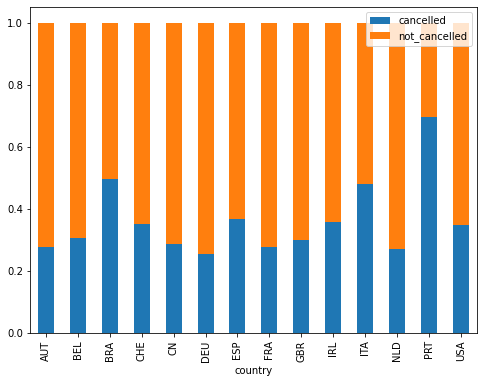

In [976]:
get_cancellation_prob(b_data[b_data['country'].isin(most_frequent_countries)], 'country')

##### Deposit Policy

The 'Refundable' class doesn't have enough representation, the 'Non Refund' class has about 99% cancellation probability.

- We will be dropping this feature, there's something not right about it. It doesn't feel right for 99% of the non refund deposits to result in booking cancellations.

In [977]:
b_data['deposit_policy'].value_counts(normalize = True)

No Deposit    0.833191
Non Refund    0.165477
Refundable    0.001332
Name: deposit_policy, dtype: float64

In [978]:
bootstraping_prob(b_data, 'deposit_policy', n = 100)

category confidence_interval      mean
0  No Deposit         (0.4, 0.41)  0.404778
1  Non Refund         (0.99, 1.0)  0.996001
2  Refundable        (0.11, 0.57)  0.300000

<AxesSubplot:xlabel='deposit_policy'>

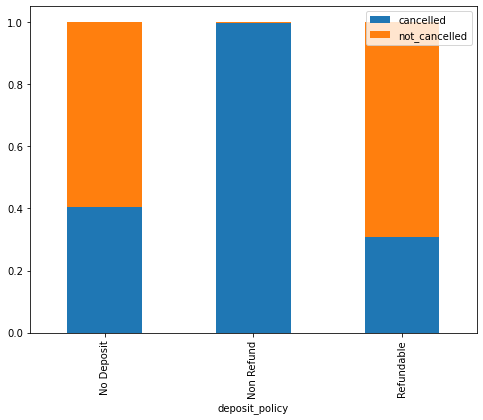

In [979]:
get_cancellation_prob(b_data, 'deposit_policy')

#### Booking data

This group has several features, all them are related to the booking information. As we made some feature engineering before some variables will have similar interpretation and so we won't need to analyze both (the original and the new one)

In [980]:
booking_columns = ['agency?', 'avg_price', 'booking_arrival_distance', 'booking_changed?', 'breakfast',
                  'cancellled_before?','changes_between_booking_arrival','days_between_booking_arrival',
                  'id_travel_agency_booking', 'num_adults', 'num_babies', 'num_children', 'num_of_guests',
                  'num_weekend_nights', 'num_workweek_nights','repeated_guest', 'required_car_parking_spaces', 
                  'required_parking_space?', 'reserved_room', 'specia_requests?', 'total_nights', 'total_of_special_requests',
                  'week_number_arrival_date', 'year_season', 'booking month']

##### Arrival month and season

Sadly the month and season variables were not very informative to us. They are technically tied according to the confidence interval.

In [981]:
b_data['booking_month'].value_counts(normalize = True) 

8     0.116622
7     0.106921
5     0.100864
4     0.095331
6     0.093600
10    0.093577
9     0.088966
3     0.080222
2     0.066047
12    0.055732
11    0.054946
1     0.047170
Name: booking_month, dtype: float64

In [982]:
bootstraping_prob(b_data, 'booking_month', n = 100)

category confidence_interval      mean
0        1.0        (0.39, 0.47)  0.432133
1        2.0         (0.44, 0.5)  0.463457
2        3.0        (0.42, 0.48)  0.447916
3        4.0        (0.52, 0.57)  0.536450
4        5.0         (0.5, 0.56)  0.526657
5        6.0        (0.52, 0.58)  0.544327
6        7.0        (0.48, 0.53)  0.502116
7        8.0        (0.49, 0.53)  0.509992
8        9.0         (0.5, 0.56)  0.524987
9       10.0        (0.49, 0.54)  0.516824
10      11.0         (0.4, 0.48)  0.443390
11      12.0        (0.44, 0.52)  0.482859

<AxesSubplot:xlabel='booking_month'>

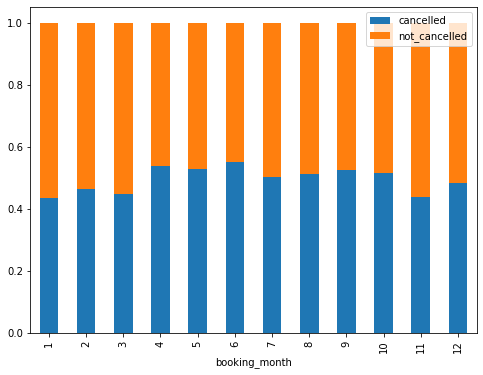

In [983]:
get_cancellation_prob(b_data, 'booking_month')

In [984]:
bootstraping_prob(b_data, 'year_season', n = 100)

category confidence_interval      mean
0     fall        (0.48, 0.52)  0.501525
1   spring        (0.49, 0.52)  0.506937
2   summer         (0.5, 0.53)  0.521353
3   winter        (0.44, 0.48)  0.464899

<AxesSubplot:xlabel='year_season'>

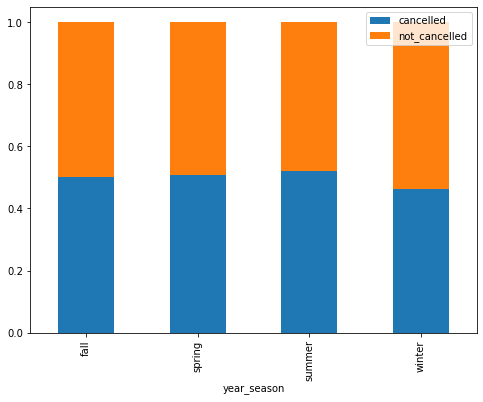

In [985]:
get_cancellation_prob(b_data, 'year_season')

##### Average price

The distribution of the price is basically the same among cancelled and not cancelled bookings. The analysis suggests that the price itself is not a meaningfull factor for the cancellation event.

In [986]:
b_data['avg_price'].describe()

count    87831.000000
mean       102.970355
std         46.828091
min          0.000000
25%         70.000000
50%         95.000000
75%        126.000000
max        300.000000
Name: avg_price, dtype: float64

In [987]:
bootstraping_prob(b_data, 'hotel_price_range', n = 100)

category confidence_interval      mean
0      3.0        (0.48, 0.56)  0.517471
1        0        (0.46, 0.49)  0.474550
2        1         (0.5, 0.53)  0.514876
3        2         (0.5, 0.53)  0.516834

<AxesSubplot:xlabel='hotel_price_range'>

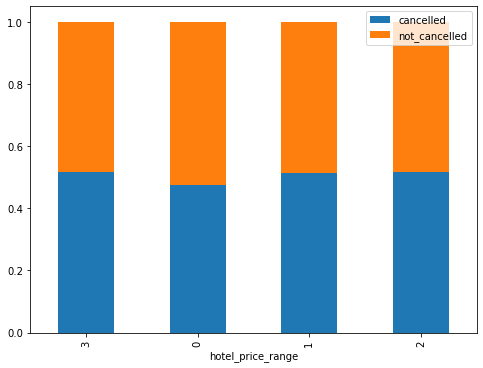

In [988]:
get_cancellation_prob(b_data, 'hotel_price_range')

<AxesSubplot:xlabel='cancellation', ylabel='avg_price'>

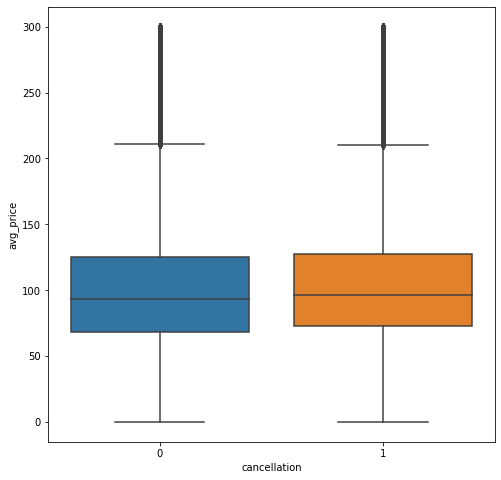

In [989]:
plt.figure(figsize = (8,8))
sns.boxplot(x='cancellation', y='avg_price', data = b_data)

# Prediction model

Predicting the cancellation event for a given booking is a binary classification task, even though there are many reliable classification algorithms we choose to use the three based model Random Forest (RF), the RF performs well in the vast majority of the cases.

## Selecting the usable variables

Since we haven't explored and transformed all the available variables we'll select the usable ones to train our classification model.

Some of the categorical columns could be easly processed by One-hot-encoding and for those we decided to perform the conversion.

*Note: We are aware that this implementation of the p_country feature will insert some data leaking into the model, we will proceed using it for now but for the future we must modify the implementationt o avoid the leaking.*

In [1083]:
b_data['high_cancellation_market'] = get_high_cancellation_market(b_data)
b_data['low_cancellation_market'] = get_low_cancellation_market(b_data)
b_data['p_country'] = get_p_country(b_data)

classification_cols = ['days_between_booking_arrival', 'num_weekend_nights', 'num_workweek_nights',
 'num_adults','num_children', 'num_babies', 'repeated_guest', 'num_previous_cancellations',
 'num_previous_stays','changes_between_booking_arrival', 'customer_type', 'distribution_channel',
 'avg_price', 'required_car_parking_spaces', 'total_of_special_requests', 'fancy_hotel?',
 'booking_arrival_distance', 'total_nights', 'num_of_guests', 'cancellled_before?',
 'booking_changed?', 'hotel_price_range', 'required_parking_space?', 'special_requests?',
 'year_season', 'reserved_room', 'high_cancellation_market', 'low_cancellation_market','p_country']

oht_cols = ['distribution_channel', 'customer_type', 'reserved_room','year_season']

classification_df = b_data[classification_cols]
target = b_data['cancellation']

for col in oht_cols:
    ohe = OneHotEncoder()
    data = ohe.fit_transform(classification_df[col].values.reshape(-1, 1)).toarray()
    col_names = ohe.get_feature_names([col])
    
    classification_df[col_names] = data
    
    classification_df = classification_df.drop(columns = col)

classification_df

<ipython-input-1083-87a2c88c98a2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df[col_names] = data
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


days_between_booking_arrival  num_weekend_nights  num_workweek_nights  \
10756                           221                   1                    1   
57278                            71                   0                    4   
22658                           254                   1                    1   
32520                            18                   1                    0   
10671                           244                   2                    5   
...                             ...                 ...                  ...   
67667                           126                   2                    5   
78774                           179                   3                    6   
77683                           111                   2                    1   
71006                           176                   2                    2   
53560                            20                   2                    1   

       num_adults  num_children  num_babies  repeated_guest  \
10756           2           0.0           0               0   
57278           1           0.0           0               0   
22658           2           0.0           0               0   
32520           2           0.0           0               0   
10671           2           0.0           0               0   
...           ...           ...         ...             ...   
67667           2           0.0           0               0   
78774           2           0.0           0               0   
77683           2           0.0           0               0   
71006           2           0.0           0               0   
53560           2           1.0           0               0   

       num_previous_cancellations  num_previous_stays  \
10756                           1                   0   
57278                           0                   0   
22658                           0                   0   
32520                           0                   0   
10671                           1                   0   
...                           ...                 ...   
67667                           0                   0   
78774                           0                   0   
77683                           0                   0   
71006                           0                   0   
53560                           0                   0   

       changes_between_booking_arrival  ...  reserved_room_D  reserved_room_E  \
10756                                0  ...              0.0              0.0   
57278                                0  ...              0.0              0.0   
22658                                0  ...              0.0              0.0   
32520                                0  ...              0.0              0.0   
10671                                0  ...              0.0              0.0   
...                                ...  ...              ...              ...   
67667                                0  ...              1.0              0.0   
78774                                0  ...              0.0              0.0   
77683                                2  ...              0.0              0.0   
71006                                0  ...              0.0              0.0   
53560                                0  ...              0.0              0.0   

       reserved_room_F  reserved_room_G reserved_room_H  reserved_room_L  \
10756              0.0              0.0             0.0              0.0   
57278              0.0              0.0             0.0              0.0   
22658              0.0              0.0             0.0              0.0   
32520              0.0              0.0             0.0              0.0   
10671              0.0              0.0             0.0              0.0   
...                ...              ...             ...              ...   
67667              0.0              0.0             0.0              0.0   
78774              0.0 

## Creating model and displaying the results

As mentioned before, we decided to instance a Random Forest model as it performs well for most classification tasks.
We validated the results with a crossvalidation setup of 10 folds. Altough the temporal split of the dataset (recent samples -> validation / older samples -> training) is more suited to predict the behavior of the model for future entries, the crossvalidation approach brings more stability and reliability to the results analysis.

The model displayed very good results while remained consistent among the classes:

**Accuracy**: 85%

**ROC_AUC**: 0.93

**F1-Score**: 85%


In [1085]:
rf = RandomForestClassifier(random_state = 42)

cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 42 )

scores = pd.DataFrame()

cv_results = cross_validate(rf, classification_df, target, cv  = cv_split, 
                            scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

In [1086]:
results = pd.DataFrame()
results['accuracy'] = cv_results['test_accuracy']
results['roc_auc'] = cv_results['test_roc_auc']
results['precisiom'] = cv_results['test_precision']
results['recall'] = cv_results['test_recall']
results['f1-score'] = cv_results['test_f1']
results

accuracy   roc_auc  precisiom    recall  f1-score
0  0.851803  0.933933   0.865344  0.834518  0.849652
1  0.852751  0.936165   0.864172  0.837864  0.850815
2  0.849564  0.934536   0.863665  0.833959  0.848552
3  0.855180  0.936503   0.871357  0.836492  0.853569
4  0.856395  0.937333   0.870462  0.838888  0.854383
5  0.852258  0.934912   0.865330  0.835690  0.850252
6  0.854573  0.936445   0.867604  0.840075  0.853618
7  0.852713  0.936229   0.869272  0.833371  0.850943
8  0.848880  0.934023   0.857266  0.835986  0.846492
9  0.851537  0.935449   0.864369  0.836635  0.850276

In [1089]:
results.mean()

accuracy     0.852565
roc_auc      0.935553
precisiom    0.865884
recall       0.836348
f1-score     0.850855
dtype: float64

## Feature importance

Taking a quick look at the importances attributed by the Random Forest model we could notice that the most important variables to decide wether a booking will result in a cancellation or not are:

- **days_between_booking_arrival** : it seems that as far the booking is from the arrival, as likely is the booking to be cancelled.
- **p_country**: as mentioned before, different countries have different cancellation profiles.
- **avg_price**: the variable performed suprisingly well in this tree based model, we'll need to perform further analysis on it to understand how it affects the cancellation event.

In [1087]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(classification_df, target)

RandomForestClassifier(random_state=42)

In [1088]:
f_importance = pd.DataFrame(index = classification_df.columns)
f_importance['score'] = rf.feature_importances_
f_importance.sort_values('score', ascending = False)

score
days_between_booking_arrival     0.150097
p_country                        0.144622
avg_price                        0.119716
booking_arrival_distance         0.056880
total_nights                     0.041991
total_of_special_requests        0.041696
num_workweek_nights              0.038562
customer_type_0                  0.032370
special_requests?                0.032154
num_weekend_nights               0.026420
hotel_price_range                0.023842
customer_type_2                  0.022722
required_car_parking_spaces      0.017895
changes_between_booking_arrival  0.016886
num_previous_cancellations       0.016864
required_parking_space?          0.016047
cancellled_before?               0.015456
high_cancellation_market         0.015354
num_of_guests                    0.015319
booking_changed?                 0.013975
fancy_hotel?                     0.013895
num_adults                       0.011551
year_season_summer               0.010704
year_season_spring               0.010410
low_cancellation_market          0.010327
distribution_channel_2           0.010007
year_season_fall                 0.009792
reserved_room_A                  0.008851
year_season_winter               0.008336
reserved_room_D                  0.007785
distribution_channel_0           0.006816
num_children                     0.005955
num_previous_stays               0.004693
reserved_room_E                  0.004363
customer_type_1                  0.003843
distribution_channel_1           0.002616
repeated_guest                   0.002572
reserved_room_F                  0.002092
reserved_room_G                  0.001727
reserved_room_B                  0.001621
reserved_room_C                  0.001025
num_babies                       0.000911
reserved_room_H                  0.000506
customer_type_3                  0.000370
distribution_channel_4           0.000340
reserved_room_L                  0.000025

# Next steps

Due to the limited time to perform this analysis some very important steps of the modeling proccess were left aside.

- Exploratory analysis for all available features.
- Exploratory analysis of nested variables, for example: country + month
- Proper feature selection and dimensional reduction in the dataset to optimize our results.
- Model selection to select the algorithm that better fit the task needs.
- Hyper parameter optimization to enhance models performance.
